### Compare the performance of GPUCB and QuantUCB on toy data

Cheng: There is a bandit algorithm, called GP-UCB, which looks at estimating the upper confidence bound using Gaussian processes, and then choosing the point that maximises the UCB as the point to sample. The idea is to do Quant-UCB, which is to use a quantile (e.g. 90%) instead of the Gaussian variance.

This notebook is to compare the performance of GPUCB and QuantUCB.

##### Dataset

I use the optwok toy dataset: gaussproc_06_20_0.1.pkl, which contains 'data' object with data.examples, data.context, data.labels. The dataset contains 6 contexts, we choose to use one of the context to do experiments (i.e. 20 samples).

##### Setting

The initial setting is for GPUCB, we use the same beta formula specified in CGP-UCB implementation. [Seems to be different from the paper formula??]

For QuantUCB, there is two ideas for finding the point to observe:

(1) MUB: find the index which returns the maximum uppper bound. The upper bound is specified by the upper quantile, which changes along epoches: argmax $\tau_{q(t)} (x)$ 

(2) MPV: Similar to GPUCB, we also consider the predictions (median) and variance (e.g. (upper bound - lower bound)/2):
argmax $\mu(x) + \beta_t \frac{1}{2} (uq - lq)$


##### TODO:

[TODO: theoretically prove how the upper quantile or beta changes for Quant-UCB.]

[TODO: Kernel quantile regression optimization cross problem]

[TODO: Sequential quantile regression]

In [1]:
# coding: utf-8
import numpy as np
from matplotlib import pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.kernel_approximation
import scipy.optimize as opt
import UCB
from UCB import DummyEnvironment
from pickle import load
import bz2
import optwok
import random
import qreg
%matplotlib inline

ModuleNotFoundError: No module named 'qreg'

[ 0.97865616  1.21631322  3.46039948  1.71944036  4.3994482   4.64535665
  2.27241345  2.86453348  3.87559873  0.46395358  2.97992002  1.85938708
  3.08696396  2.12573766  1.16336572  0.91043824  0.92165354  3.29304392
  0.85687616  0.13249109]
[ 1.14667483  0.94237935 -0.82739665  0.05877703 -0.69598727 -0.98917386
 -0.4255412  -0.39174391 -0.58768367  1.06612883 -0.66971829 -0.10961714
 -0.64510426 -0.18808117  1.1881707   1.20358293  1.19599381 -0.65006979
  1.14020758  0.68052653]


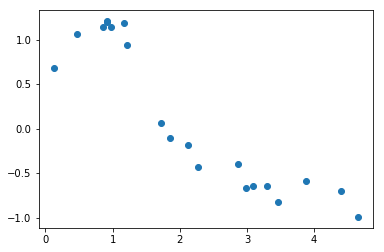

In [2]:
num_ex = 50
f = bz2.BZ2File('gaussproc_06_20_0.1.pkl', 'rb')
data = load(f, encoding='latin1')
x = data.examples[0][0:20]
t = data.labels[0:20]

plt.scatter(x,t)
print(x)
print(t)

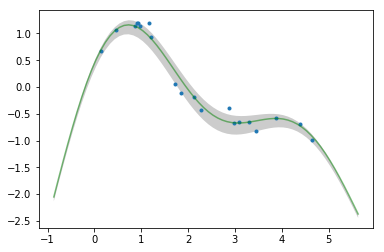

In [3]:
# test quantile regression using qreg library

from qreg import QRegressor

min_val = min(x)
max_val = max(x)
test_range = np.arange(min_val - 1, max_val + 1, 0.1)
num_test = len(test_range)

#probs = np.linspace(0.1,0.9,3)
probs = [0.1,0.5,0.9]
reg = QRegressor(C=1e2, probs=probs, gamma_out=1e-2, max_iter=1e4, verbose=False, lag_tol=1e-3, active_set=True)
reg.fit(x,t, probs)
pred = reg.predict(test_range)
plt.plot(x,t,'.')
#for q in pred:
#    plt.plot(test_range, q, '-')
plt.plot(test_range, pred[1], alpha=0.5, color='g', label = 'predict')
plt.fill_between(test_range, pred[0], pred[2], facecolor='k', alpha=0.2)

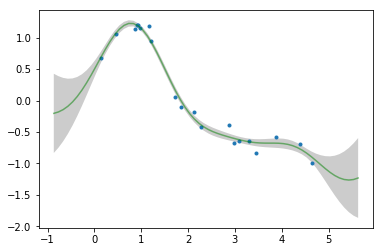

In [4]:
# test on gaussian process regression

from sklearn.gaussian_process import GaussianProcessRegressor

gp = GaussianProcessRegressor(alpha = 0.01)
gp.fit(x.reshape((x.shape[0],1)), t)
mu, sigma = gp.predict(test_range.reshape((test_range.shape[0],1)), return_std=True)

plt.plot(x,t,'.')
plt.plot(test_range, mu, alpha=0.5, color='g', label = 'predict')
plt.fill_between(test_range, mu - sigma, mu + sigma, facecolor='k', alpha=0.2)
plt.show()

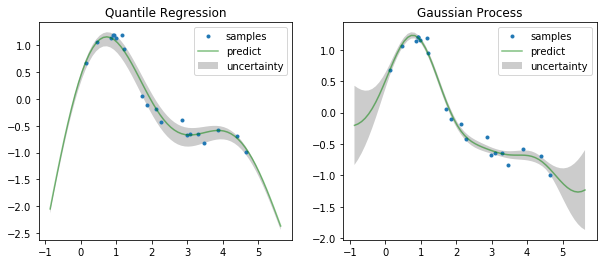

In [5]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(x,t,'.', label = 'samples')
plt.plot(test_range, pred[1], alpha=0.5, color='g', label = 'predict')
plt.fill_between(test_range, pred[0], pred[2], facecolor='k', alpha=0.2, label = 'uncertainty')
plt.title('Quantile Regression')
plt.legend()

plt.subplot(1,2,2)
plt.plot(x,t,'.', label = 'samples')
plt.plot(test_range, mu, alpha=0.5, color='g', label = 'predict')
plt.fill_between(test_range, mu - sigma, mu + sigma, facecolor='k', alpha=0.2, label = 'uncertainty')
plt.title('Gaussian Process')
plt.legend()
plt.show()

Compare the two regression plot, we can observe that for area having few samples, the quantile regression with different tend to predict same (low variance), while the gaussian process regression tend to have large variance

In [69]:
init_list = np.random.choice(len(x), 3, replace=False)
print(x[init_list])
print(t[init_list])

[ 2.86453348  1.16336572  1.21631322]
[-0.39174391  1.1881707   0.94237935]


In [6]:
init_list = [7,14,1]

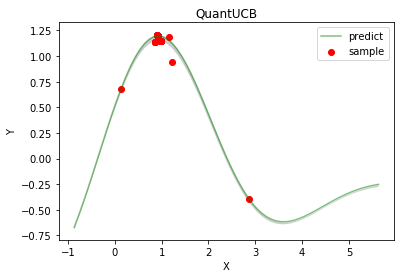

In [7]:
# plot fit performance for uq = 0.8
QuantAgent = UCB.QuantUCB(x, t, init_list, uq = 0.8, uq_rate = 0.002)
for i in range(num_ex):
    QuantAgent.learn(i)
QuantAgent.plot()

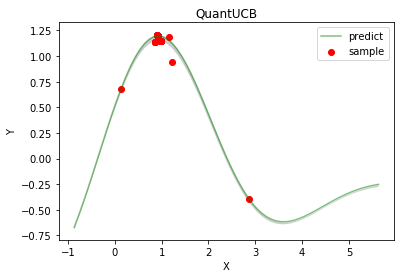

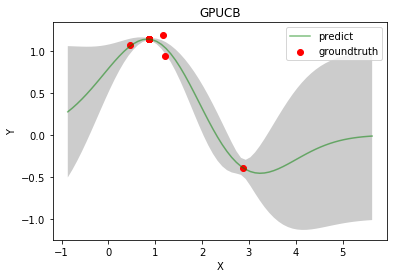

In [12]:
# perform GPUCB and plot the predictions with samples

alpha = 0.01 
GPAgent = UCB.GPUCB(x, t, init_list, alpha)
for i in range(num_ex):
    GPAgent.learn(i) 
GPAgent.plot()

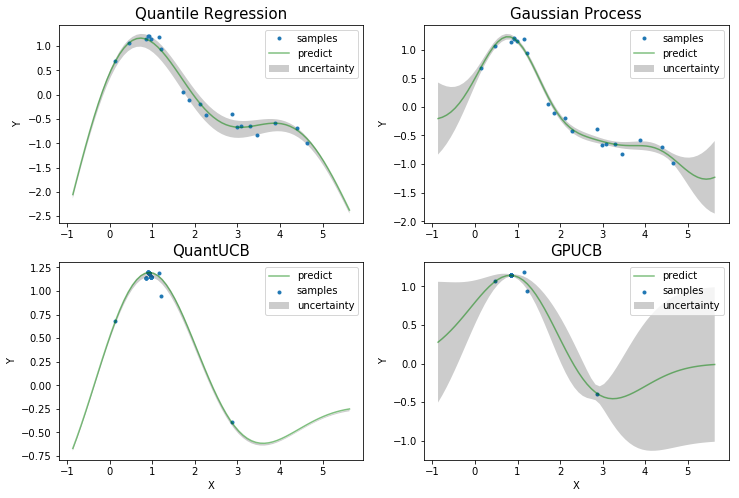

In [30]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(x,t,'.', label = 'samples')
plt.plot(test_range, pred[1], alpha=0.5, color='g', label = 'predict')
plt.fill_between(test_range, pred[0], pred[2], facecolor='k', alpha=0.2, label = 'uncertainty')
plt.title('Quantile Regression', fontsize = '15')
plt.ylabel('Y')
plt.legend()

plt.subplot(2,2,2)
plt.plot(x,t,'.', label = 'samples')
plt.plot(test_range, mu, alpha=0.5, color='g', label = 'predict')
plt.fill_between(test_range, mu - sigma, mu + sigma, facecolor='k', alpha=0.2, label = 'uncertainty')
plt.title('Gaussian Process', fontsize = '15')
plt.ylabel('Y')
plt.legend()

plt.subplot(2,2,3)
min_val = min(QuantAgent.x)
max_val = max(QuantAgent.x)
test_range = np.arange(min_val - 1, max_val + 1, 0.1)
num_test = len(test_range)
#test_range.shape = (num_test, 1)

plt.scatter(QuantAgent.X, QuantAgent.T, marker='.', alpha=1.0, label = 'samples')
plt.plot(test_range, QuantAgent.pred[1], alpha=0.5, color='g', label = 'predict')
plt.fill_between(test_range, QuantAgent.pred[0], QuantAgent.pred[2], facecolor='k', alpha=0.2, label = 'uncertainty')

#plt.savefig('fig_%02d.png' % len(self.X))
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('QuantUCB', fontsize = '15')

plt.subplot(2,2,4)
min_val = min(GPAgent.x)
max_val = max(GPAgent.x)
test_range = np.arange(min_val - 1, max_val + 1, 0.1)
num_test = len(test_range)
#test_range.shape = (num_test, 1)

#(self.preds, self.pred_var) = self.gp.predict(test_range.reshape(num_test,1), return_std= True)
plt.scatter(GPAgent.X, GPAgent.T, marker='.', alpha=1.0, label = 'samples')
plt.plot(test_range, GPAgent.preds, alpha=0.5, color='g', label = 'predict')
plt.fill_between(test_range, GPAgent.preds - GPAgent.pred_var, 
                GPAgent.preds + GPAgent.pred_var, facecolor='k', alpha=0.2, label = 'uncertainty')

#ax.plot(self.x, self.mu, alpha=0.5, color='g', label = 'predict')
#ax.fill_between(self.x, self.mu + self.sigma, self.mu - self.sigma, facecolor='k', alpha=0.2)

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('GPUCB', fontsize = '15')
plt.savefig('Exper.pdf')

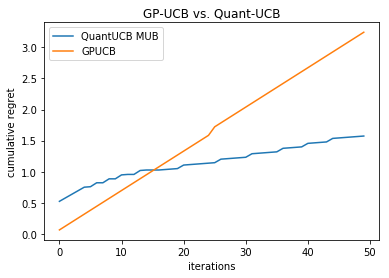

In [22]:
#plot cumulative regret

#plt.plot(range(num_ex), QuantAgent_MUB.regret_list, label = 'QuantUCB MUB')
#plt.plot(range(num_ex), QuantAgent_MPV.regret_list, label = 'QuantUCB MPV')
plt.plot(range(num_ex), QuantAgent.regret_list, label = 'QuantUCB MUB')
#plt.plot(range(num_ex), Quant_regret, label = 'QuantUCB')
#plt.plot(range(num_ex), Quant_regret_noinc, label = 'QuantUCB NoInc')
plt.plot(range(num_ex), GPAgent.regret_list, label = 'GPUCB')
plt.xlabel('iterations')
plt.ylabel('cumulative regret')
plt.title('GP-UCB vs. Quant-UCB')
plt.legend()

#### Experiment 1

Use "maximum upper bound" idea (i.e. (1) above), with upper quantile increasing according to "uq_rate" (e.g. 0.001) until reach to 0.95.

uq setting: [0.7,0.75,0.8,0.85,0.9,0.95]

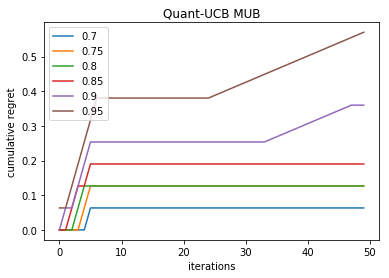

In [10]:
# perform QuantUCB with uq increasing by 0.001 per epoch

uq_list = [0.7,0.75,0.8,0.85,0.9,0.95]

from collections import defaultdict
regret_dict = defaultdict(list)

for uq in uq_list:
    QuantAgent = UCB.QuantUCB(x, t, init_list, max_method='MUB', uq=uq, uq_rate = 0.001)
    for i in range(num_ex):
        QuantAgent.learn(i)
    regret_dict[uq] = QuantAgent.regret_list

for key, value in regret_dict.items():  
    plt.plot(range(num_ex), value, label = key)
plt.xlabel('iterations')
plt.ylabel('cumulative regret')
plt.title('Quant-UCB MUB')
plt.legend()

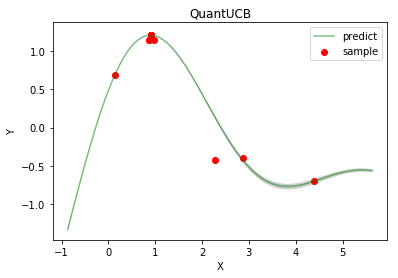

In [16]:
# plot fit performance for uq = 0.8
QuantAgent_MUB = UCB.QuantUCB(x, t, init_list, max_method='MUB', uq=0.75, uq_rate = 0.001)
for i in range(num_ex):
    QuantAgent_MUB.learn(i)
QuantAgent_MUB.plot()

#### Experiment 2

Use "maximum predict + variance" idea (i.e. (2) above), with similar formula for beta:

if len(self.X) > 0:     
    self.beta = np.log(len(self.X) * (epoch + 1.0))/20  
return np.argmax(self.predict + 0.5 * abs(self.ub - self.lb) * self.beta)

uq and corresponding lq:
uq: [0.7,0.75,0.8,0.85,0.9,0.95]
lq: [0.3,0.25,0.2,0.15,0.1,0.05]

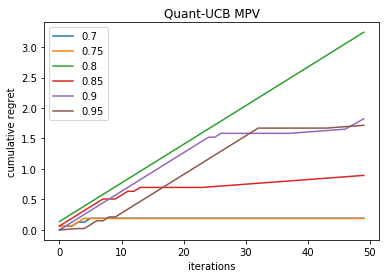

In [12]:
# perform QuantUCB with uq fixed at 0.8 

uq_list = [0.7,0.75,0.8,0.85,0.9,0.95]
lq_list = [0.3,0.25,0.2,0.15,0.1,0.05]

from collections import defaultdict
regret_dict = defaultdict(list)

for i in range(len(uq_list)):
    QuantAgent = UCB.QuantUCB(x, t, init_list, max_method='MPV', 
                              uq=uq_list[i], lq=lq_list[i])
    for j in range(num_ex):
        QuantAgent.learn(j)
    regret_dict[uq_list[i]] = QuantAgent.regret_list

for key, value in regret_dict.items():  
    plt.plot(range(num_ex), value, label = key)
plt.xlabel('iterations')
plt.ylabel('cumulative regret')
plt.title('Quant-UCB MPV')
plt.legend()

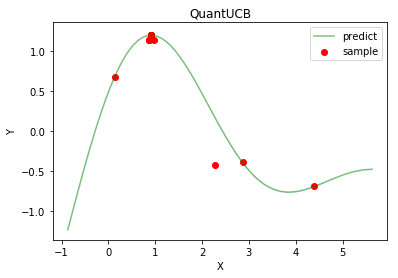

In [18]:
QuantAgent_MPV = UCB.QuantUCB(x, t, init_list, max_method='MPV', 
                              uq=0.75, lq=0.25)
for j in range(num_ex):
    QuantAgent_MPV.learn(j)
QuantAgent_MPV.plot()     

### Setting:

GPUCB:  beta is the same as CGP-UCB implement setting
QuantUCB MUB: idea (1) with increasing upper quantiles (from 0.8 to 0.95)  
QuantUCB MPV: idea (2) with fixed upper quantiles (0.8) and beta changes as specified above (Exp 2)

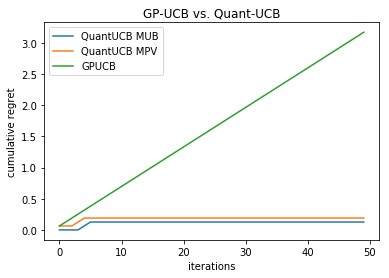

In [19]:
#plot cumulative regret

plt.plot(range(num_ex), QuantAgent_MUB.regret_list, label = 'QuantUCB MUB')
plt.plot(range(num_ex), QuantAgent_MPV.regret_list, label = 'QuantUCB MPV')
#plt.plot(range(num_ex), QuantAgent.regret_list, label = 'QuantUCB MUB')
#plt.plot(range(num_ex), Quant_regret, label = 'QuantUCB')
#plt.plot(range(num_ex), Quant_regret_noinc, label = 'QuantUCB NoInc')
plt.plot(range(num_ex), GPAgent.regret_list, label = 'GPUCB')
plt.xlabel('iterations')
plt.ylabel('cumulative regret')
plt.title('GP-UCB vs. Quant-UCB')
plt.legend()

In [15]:
'''
# perform QuantUCB for 10 times and take avarage

num_test = 10

Quant_regret = np.zeros((num_ex))
Quant_regret_noinc = np.zeros((num_ex))

for i in range(num_test):
    uq = 0.8
    lq = 0.1
    
    # increase uq with rate 0.001
    QuantAgent = UCB.QuantUCB(x, t, uq, lq)
    for i in range(num_ex):
        QuantAgent.learn()
    Quant_regret += QuantAgent.regret_list
    
    # no increase
    QuantAgent_noincrease = UCB.QuantUCB(x, t, uq, lq, uq_rate=0.0)
    for i in range(num_ex):
        QuantAgent_noincrease.learn()
    Quant_regret_noinc += QuantAgent_noincrease.regret_list
    
Quant_regret = Quant_regret/num_test
Quant_regret_noinc = Quant_regret_noinc/num_test
'''  

'\n# perform QuantUCB for 10 times and take avarage\n\nnum_test = 10\n\nQuant_regret = np.zeros((num_ex))\nQuant_regret_noinc = np.zeros((num_ex))\n\nfor i in range(num_test):\n    uq = 0.8\n    lq = 0.1\n    \n    # increase uq with rate 0.001\n    QuantAgent = UCB.QuantUCB(x, t, uq, lq)\n    for i in range(num_ex):\n        QuantAgent.learn()\n    Quant_regret += QuantAgent.regret_list\n    \n    # no increase\n    QuantAgent_noincrease = UCB.QuantUCB(x, t, uq, lq, uq_rate=0.0)\n    for i in range(num_ex):\n        QuantAgent_noincrease.learn()\n    Quant_regret_noinc += QuantAgent_noincrease.regret_list\n    \nQuant_regret = Quant_regret/num_test\nQuant_regret_noinc = Quant_regret_noinc/num_test\n'